   [Block 2] Using BRUTE FORCE QUBO solver

Online optimization step 0 at t = 0.00
   ADMM iter 00 | residual = 3.9508e-01 | z_binary = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] | r = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
   ADMM iter 05 | residual = 3.9660e-01 | z_binary = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] | r = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
   ADMM iter 10 | residual = 3.9788e-01 | z_binary = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] | r = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
   ADMM iter 15 | residual = 3.9897e-01 | z_binary = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] | r = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
   ADMM iter 20 | residual = 2.7705e-01 | z_binary = [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] | r = [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
   ADMM iter 25 | residual = 9.2318e-01 | z_binary = [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] | r = [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
   ADMM iter 30 | residual = 2.8497

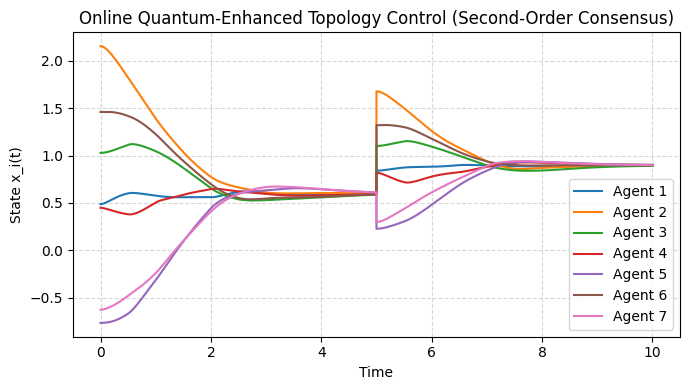

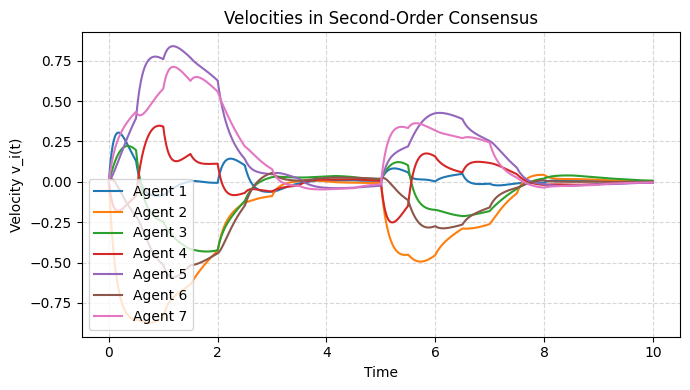

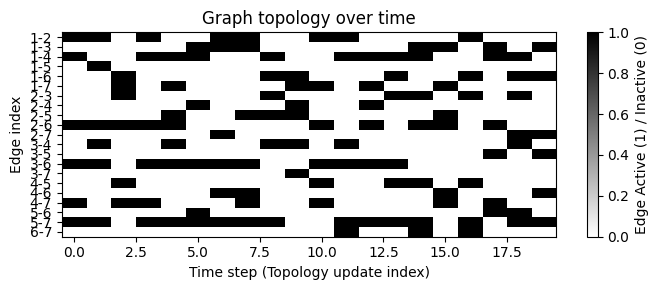

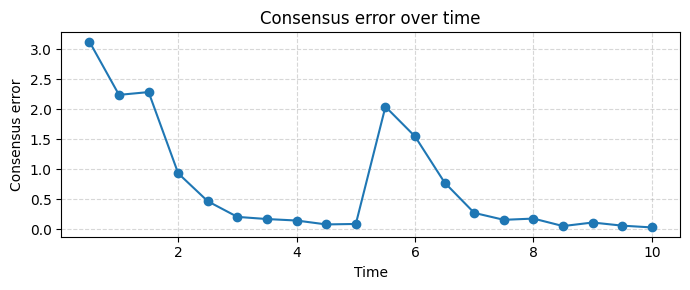


Final time: 10.0
Final state x(T): [0.89630559 0.89502501 0.89163676 0.90086196 0.90108024 0.89727131
 0.89960242]
Final velocity v(T): [ 0.00253979  0.00239289  0.00735516 -0.00446341 -0.00470113  0.00042281
 -0.00354612]
Final consensus error = 0.030637614264206844


In [21]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import Estimator
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms import VarQITE
from qiskit_algorithms.time_evolvers import TimeEvolutionProblem
from qiskit_algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple
np.random.seed(0)

# ============================================================
# 0) Global configuration
# ============================================================

# Number of agents (adjustable)
N_AGENTS = 7

# Dynamics mode: 1 = first-order consensus, 2 = second-order consensus
DYNAMICS_ORDER = 2   # or 2

# Second-order control gains (used only if DYNAMICS_ORDER == 2)
ALPHA = 3.0
BETA = 3.0

USE_BRUTE_FORCE = True   # set True while debugging ADMM,
                          # set False to use QITE

next_jump_time = 5.0  # first jump time (seconds)

# Initial positions (length must match N_AGENTS)
X0 = np.random.uniform(-5.0, 5.0, size=N_AGENTS)

# Initial velocities for second-order case
# (if DYNAMICS_ORDER == 2, length must match N_AGENTS)
V0 = np.zeros(N_AGENTS)

# Candidate undirected edges (0-based indices): use complete graph
edge_list = [(i, j) for i in range(N_AGENTS) for j in range(i + 1, N_AGENTS)]
M_EDGES = len(edge_list)

# Degree penalty coefficients (kappa_i >= 0)
kappa = 0.1 * np.ones(N_AGENTS)

# Maximum degree gamma (must satisfy 2 <= gamma <= N_AGENTS - 1 for n >= 3)
gamma = 2

# ADMM hyperparameters
rho = 20         # penalty on (z - r + s)
# beta: penalty on s, chosen based on N_AGENTS
if N_AGENTS <= 4:
    beta = 90
elif N_AGENTS == 5:
    beta = 200
elif N_AGENTS == 6:
    beta = 400
elif N_AGENTS == 7:
    beta = 600
else:
    growth_ratio = 500.0 / 400.0
    extra_agents = N_AGENTS - 6
    beta = int(round(400 * (growth_ratio ** extra_agents)))

mu_card = 0.1       # penalty on (sum r_i)^2 in QUBO
max_admm_iters = 500
admm_tol = 1e-3

# QITE hyperparameters
QITE_TAU = 1.5
QITE_STEPS = 30
QITE_REPS = 1
TOP_K = 16   # number of top bitstrings (by probability) to evaluate true QUBO cost

# Closed-loop simulation
DT_UPDATE = 0.5     # duration between topology re-optimizations
T_MAX = 10.0        # safety cap on total time
CONS_TOL = 1e-3     # consensus error tolerance

np.random.seed(0)


# ============================================================
# 1) Helper: incidence, degrees, Laplacian
# ============================================================

def edge_incidence_matrix(n_agents, edges):
    """
    Build E in R^{n_agents x m}, where column e corresponds to
    undirected edge (i,j) and has 1 in row i and 1 in row j.
    """
    m = len(edges)
    E = np.zeros((n_agents, m))
    for e_idx, (i, j) in enumerate(edges):
        E[i, e_idx] = 1.0
        E[j, e_idx] = 1.0
    return E


Edeg = edge_incidence_matrix(N_AGENTS, edge_list)


def build_degree_vector(z):
    """Degree vector deg(i) = sum_{e incident on i} z_e."""
    return Edeg @ z


def build_laplacian_from_z(z):
    """
    Build Laplacian L from binary (or relaxed) edge indicators z.
    Edge is "on" if z_e > 0.5.
    """
    L = np.zeros((N_AGENTS, N_AGENTS))
    for e_idx, (i, j) in enumerate(edge_list):
        if z[e_idx] > 0.5:
            L[i, j] -= 1.0
            L[j, i] -= 1.0
            L[i, i] += 1.0
            L[j, j] += 1.0
    return L


# ============================================================
# 2) Block 1: relaxed QP in (z, flows)
# ============================================================

def build_edge_costs_from_positions(x):
    """
    For each edge (i,j), define a linear weight:
        w_ij = c_comm + d_ij
    where c_comm = 1.0 and d_ij = |x_i - x_j|.
    """
    c_comm = 1.0
    d_ij = np.array([abs(x[i] - x[j]) for (i, j) in edge_list])
    w_ij = c_comm + d_ij
    return w_ij


def block1_solve(w_ij, r, s, lam):
    """
    Block 1: given w_ij (current edge weights) and current (r, s, lam),
    solve convex QP in (z, f_plus, f_minus):

        min_z,f  sum_e w_ij z_e
                 + sum_i kappa_i deg(i)^2
                 + lam^T (z - r + s)
                 + (rho/2) ||z - r + s||^2

        s.t.   0 <= z_e <= 1
               deg(i) <= gamma
               connectivity via flow constraints (rooted flow)

    Outputs:
        z_val      (M_EDGES,)
        f_plus_val (M_EDGES,)
        f_minus_val(M_EDGES,)
    """
    m = M_EDGES
    n = N_AGENTS

    # Variables
    z = cp.Variable(m)
    f_plus = cp.Variable(m, nonneg=True)   # flow i -> j
    f_minus = cp.Variable(m, nonneg=True)  # flow j -> i

    # Linear cost
    J_lin = w_ij @ z

    # Degree quadratic cost
    deg_vec = Edeg @ z
    J_deg = cp.sum(cp.multiply(kappa, cp.square(deg_vec)))

    # ADMM penalty on z vs (r, s)
    J_admm = lam @ (z - r + s) + (rho / 2.0) * cp.sum_squares(z - r + s)

    objective = cp.Minimize(J_lin + J_deg + J_admm)

    constraints = []

    # Box constraints on z
    constraints += [z >= 0, z <= 1]

    # Degree constraints deg(i) <= gamma
    constraints += [deg_vec <= gamma]

    # Connectivity via flow
    r_node = 0  # root index (0-based)

    # capacity constraints: flows only allowed on active edges (scaled)
    for e_idx, (i, j) in enumerate(edge_list):
        constraints += [
            f_plus[e_idx] <= (n - 1) * z[e_idx],
            f_minus[e_idx] <= (n - 1) * z[e_idx],
        ]

    # flow conservation
    inflow = [0.0] * n
    outflow = [0.0] * n

    for e_idx, (i, j) in enumerate(edge_list):
        # arc i -> j : f_plus[e_idx]
        # arc j -> i : f_minus[e_idx]
        inflow[i]  = inflow[i]  + f_minus[e_idx]
        outflow[i] = outflow[i] + f_plus[e_idx]
        inflow[j]  = inflow[j]  + f_plus[e_idx]
        outflow[j] = outflow[j] + f_minus[e_idx]

    for k_node in range(n):
        if k_node == r_node:
            constraints += [outflow[k_node] - inflow[k_node] == n - 1]
        else:
            constraints += [inflow[k_node] - outflow[k_node] == 1]

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS, verbose=False)

    if prob.status not in ["optimal", "optimal_inaccurate"]:
        print("Warning: Block 1 QP did not converge, status:", prob.status)

    return z.value, f_plus.value, f_minus.value


# ============================================================
# 3) Block 2: QUBO in r via QITE (or brute force)
# ============================================================

def build_qubo_for_r(z, s, lam):
    """
    Build Q, q for QUBO:
        J(r) = lam^T (z - r + s)
             + (rho/2) ||z - r + s||^2
             + mu_card (sum_i r_i)^2
    with r in {0,1}^m.
    """
    z = np.asarray(z)
    s = np.asarray(s)
    lam = np.asarray(lam)
    m = len(z)

    # Part 1: lam^T (z - r + s) -> linear term in r
    q1 = -lam

    # Part 2: (rho/2) ||z - r + s||^2, with a = z + s
    a = z + s
    q2 = -rho * a
    Q2 = (rho / 2.0) * np.eye(m)

    # Part 3: mu_card * (sum_i r_i)^2
    Q3 = mu_card * np.ones((m, m))

    q = q1 + q2
    Q = Q2 + Q3
    return Q, q


def qubo_to_hamiltonian(Q, q):
    """
    Map QUBO in r to Ising Hamiltonian H(Z) (up to constant offset),
    using r_i = (1 - Z_i)/2, where Z_i has eigenvalues ±1.
    """
    m = Q.shape[0]
    h = np.zeros(m)
    Jij = np.zeros((m, m))

    # Off-diagonal contributions i < j
    for i in range(m):
        for j in range(i + 1, m):
            cij = Q[i, j] + Q[j, i]
            # cij * r_i r_j = cij * 1/4 (1 - Z_i - Z_j + Z_i Z_j)
            Jij[i, j] += (cij / 4.0)
            h[i] += (-cij / 4.0)
            h[j] += (-cij / 4.0)
            # constant term ignored

    # Diagonal + linear q
    for i in range(m):
        Qi = Q[i, i]
        # Qi r_i = Qi * (1 - Z_i)/2
        h[i] += -Qi / 2.0
        # q_i r_i = q_i * (1 - Z_i)/2
        h[i] += -q[i] / 2.0

    # Build SparsePauliOp from h, Jij
    pauli_list = []
    coeff_list = []

    # Single Z terms
    for i in range(m):
        if abs(h[i]) > 1e-10:
            label = ["I"] * m
            # Qiskit uses |q_{m-1} ... q_0>, flip index
            label[m - 1 - i] = "Z"
            pauli_list.append("".join(label))
            coeff_list.append(h[i])

    # ZZ terms
    for i in range(m):
        for j in range(i + 1, m):
            if abs(Jij[i, j]) > 1e-10:
                label = ["I"] * m
                label[m - 1 - i] = "Z"
                label[m - 1 - j] = "Z"
                pauli_list.append("".join(label))
                coeff_list.append(Jij[i, j])

    if len(pauli_list) == 0:
        pauli_list = ["I" * m]
        coeff_list = [0.0]

    H = SparsePauliOp.from_list(list(zip(pauli_list, coeff_list)))
    return H


def bitstring_to_r(bitstring: str) -> np.ndarray:
    """
    Qiskit probabilities_dict() returns bitstrings in order |q_{m-1} ... q_0>.
    We want r_i to correspond to qubit i (edge i),
    so r0 is the RIGHTMOST character of the bitstring.
    """
    return np.array([int(b) for b in bitstring[::-1]], dtype=float)


def r_to_bitstring(r: np.ndarray) -> str:
    """
    Inverse mapping (optional): r_i -> bitstring in Qiskit order.
    """
    r = np.asarray(r).astype(int).tolist()
    return "".join(str(b) for b in r[::-1])


def evaluate_qubo_cost(bitstring, Q, q):
    r = bitstring_to_r(bitstring)
    return float(r.T @ Q @ r + q.T @ r)


def qite_solve_qubo(Q, q, seed=0, n_restarts=3):
    """
    Approximate QUBO minimizer using QITE ONLY (no brute force):

      - build Ising Hamiltonian H,
      - run VarQITE imaginary-time evolution from several random inits,
      - sample final state,
      - evaluate true QUBO cost on the top-K most probable bitstrings,
      - pick the best one.

    Returns:
        best_bitstring (str)
        best_cost (float)
    """
    np.random.seed(seed)
    m = Q.shape[0]

    # Build Ising Hamiltonian once
    H = qubo_to_hamiltonian(Q, q)

    candidates = []
    last_probs = None  # for fallback

    for k in range(n_restarts):
        # 1) Build ansatz & initial parameters
        ansatz = EfficientSU2(m, reps=QITE_REPS, entanglement="linear")
        init_params = 0.02 * np.random.randn(ansatz.num_parameters)

        est = Estimator()
        principle = ImaginaryMcLachlanPrinciple()
        varqite = VarQITE(
            ansatz=ansatz,
            initial_parameters=init_params,
            variational_principle=principle,
            estimator=est,
            num_timesteps=QITE_STEPS,
        )

        problem = TimeEvolutionProblem(hamiltonian=H, time=QITE_TAU)
        result = varqite.evolve(problem)
        final_circ = result.evolved_state

        # 2) Get probabilities of bitstrings
        sv = Statevector.from_instruction(final_circ)
        probs = sv.probabilities_dict()
        last_probs = probs

        items = sorted(probs.items(), key=lambda kv: kv[1], reverse=True)
        top_items = items[:min(TOP_K, len(items))]

        # 3) Evaluate true QUBO cost for these bitstrings
        for s, p in top_items:
            J = evaluate_qubo_cost(s, Q, q)
            candidates.append((s, J))

    # 4) Pick the best candidate
    if len(candidates) == 0:
        # Fallback: in case something weird happens and candidates is empty
        if last_probs is None or len(last_probs) == 0:
            s0 = "0" * m
            return s0, evaluate_qubo_cost(s0, Q, q)
        s_max = max(last_probs.items(), key=lambda kv: kv[1])[0]
        return s_max, evaluate_qubo_cost(s_max, Q, q)

    best_s, best_cost = min(candidates, key=lambda t: t[1])
    return best_s, best_cost


def solve_qubo_bruteforce(Q, q):
    """
    Exact QUBO solver by brute force:
        J(r) = r^T Q r + q^T r
    r in {0,1}^m.

    Returns:
        best_bitstring (str)
        best_cost (float)
    """
    m = Q.shape[0]
    best_s = None
    best_cost = np.inf

    for k in range(2 ** m):
        s = format(k, f"0{m}b")  # zero-padded binary string of length m
        J = evaluate_qubo_cost(s, Q, q)
        if J < best_cost:
            best_cost = J
            best_s = s

    return best_s, best_cost


# ============================================================
# 4) Block 3 and dual update
# ============================================================

def block3_update_s(z, r, lam):
    """
    s-update (unconstrained quadratic minimizer):
        s = -(lam + rho (z - r)) / (rho + beta)
    """
    return -(lam + rho * (z - r)) / (rho + beta)


def dual_update(lam, z, r, s):
    """
    lam^{+} = lam + rho (z - r + s)
    """
    return lam + rho * (z - r + s)


# ============================================================
# 5) One ADMM topology optimization step (snapshot)
# ============================================================

def admm_topology_step(x_current, z_init, r_init, s_init, lam_init, seed_base=0):
    """
    Run full 3-block ADMM to convergence for a single snapshot
    (current agent positions x_current).
    Uses warm-start (z_init, r_init, s_init, lam_init).

    Returns:
        r_final         (binary edge vector)
        f_plus_final    (directed flow i->j)
        f_minus_final   (directed flow j->i)
        z_final         (relaxed edges)
        s_final
        lam_final
        residual_history
    """
    # Build edge weights from current positions
    w_ij = build_edge_costs_from_positions(x_current)
    prev_bitstring = None
    z = z_init.copy()
    r = r_init.copy()
    s = s_init.copy()
    lam = lam_init.copy()

    residual_history = []
    f_plus_final = np.zeros(M_EDGES)
    f_minus_final = np.zeros(M_EDGES)

    for it in range(max_admm_iters):
        # Block 1: relaxed QP
        z, f_plus, f_minus = block1_solve(w_ij, r, s, lam)
        f_plus_final = f_plus
        f_minus_final = f_minus

        # Block 2: QUBO solve (either brute force or QITE)
        Q, q = build_qubo_for_r(z, s, lam)

        if USE_BRUTE_FORCE:
            bitstring, cost_qubo = solve_qubo_bruteforce(Q, q)
            r = bitstring_to_r(bitstring)

        else:
            # QITE: propose a new candidate bitstring
            bitstring_candidate, cost_candidate = qite_solve_qubo(
                Q, q, seed=seed_base + it
            )

            if it == 0 or prev_bitstring is None:
                bitstring = bitstring_candidate
                cost_qubo = cost_candidate
            else:
                cost_prev = evaluate_qubo_cost(prev_bitstring, Q, q)

                if cost_candidate < cost_prev:
                    bitstring = bitstring_candidate
                    cost_qubo = cost_candidate
                else:
                    bitstring = prev_bitstring
                    cost_qubo = cost_prev

            r = bitstring_to_r(bitstring)
            prev_bitstring = bitstring

        # Block 3: s update
        s = block3_update_s(z, r, lam)

        # Dual update
        lam = dual_update(lam, z, r, s)

        # Primal residual
        res = np.linalg.norm(z - r + s, 2)
        residual_history.append(res)

        if it % 5 == 0:
            z_bin = (z >= 0.5).astype(int)
            print(f"   ADMM iter {it:02d} | residual = {res:.4e} | "
                  f"z_binary = {z_bin} | r = {r.astype(int)}")

        if res < admm_tol:
            print(f"   ADMM converged at iter {it}, residual = {res:.4e}")
            break

    return r, f_plus_final, f_minus_final, z, s, lam, residual_history


# ============================================================
# 6) Closed-loop consensus simulation
# ============================================================

def simulate_closed_loop(L, x0, t_start, t_end,
                         dynamics_order=1, v0=None, n_points=200):
    """
    Simulate:
      - First-order consensus:  dx/dt = -L x
      - Second-order consensus: dx/dt = v, dv/dt = -ALPHA L x - BETA L v

    over [t_start, t_end] with given initial conditions.
    """
    if dynamics_order == 1:
        def dyn(t, x):
            return -L @ x

        t_span = (t_start, t_end)
        t_eval = np.linspace(t_start, t_end, n_points)

        sol = solve_ivp(dyn, t_span, x0, t_eval=t_eval,
                        method="RK45", rtol=1e-6, atol=1e-8)
        if not sol.success:
            print("Warning: closed-loop integration failed:", sol.message)

        return sol.t, sol.y  # t, X (shape N_AGENTS x len(t))

    else:
        # Second-order
        if v0 is None:
            v0 = np.zeros_like(x0)

        def dyn(t, y):
            x = y[:N_AGENTS]
            v = y[N_AGENTS:]
            dxdt = v
            dvdt = -ALPHA * (L @ x) - BETA * (L @ v)
            return np.concatenate([dxdt, dvdt])

        y0 = np.concatenate([x0, v0])
        t_span = (t_start, t_end)
        t_eval = np.linspace(t_start, t_end, n_points)

        sol = solve_ivp(dyn, t_span, y0, t_eval=t_eval,
                        method="RK45", rtol=1e-6, atol=1e-8)
        if not sol.success:
            print("Warning: closed-loop integration (2nd order) failed:",
                  sol.message)

        X = sol.y[:N_AGENTS, :]
        V = sol.y[N_AGENTS:, :]
        return sol.t, X, V


def consensus_error(L, x, v=None):
    """
    Consensus error:
      - first-order:  ||L x||_2
      - second-order: sqrt(||L x||_2^2 + ||L v||_2^2) if v is provided
    """
    err_pos = float(np.linalg.norm(L @ x, 2))
    if v is None:
        return err_pos
    err_vel = float(np.linalg.norm(L @ v, 2))
    return np.sqrt(err_pos**2 + err_vel**2)


# ============================================================
# 7) Online optimization + closed-loop until consensus
# ============================================================

def online_topology_control(dynamics_order=None):
    """
    Online loop:
      - Start from X0 (and V0 for second-order).
      - For k = 0,1,...:
          * Run ADMM (3-block, with QITE or brute force) to convergence
            at snapshot x_k.
          * Print final binary edges and flows.
          * Build L_k and simulate closed-loop dynamics over [t_k, t_{k+1}].
          * Update state at t_{k+1} and compute consensus error.
          * Stop if consensus error <= CONS_TOL or t >= T_MAX.
    """
    global next_jump_time

    if dynamics_order is None:
        dynamics_order = DYNAMICS_ORDER

    # Global time/state storage
    t_global = [0.0]
    X_global = [X0.copy()]
    V_global = []  # used only if second-order

    err_times = []
    err_values = []

    # ADMM warm start
    z_init = np.zeros(M_EDGES)
    r_init = np.zeros(M_EDGES)
    s_init = np.zeros(M_EDGES)
    lam_init = np.zeros(M_EDGES)

    edge_history = []

    t_current = 0.0
    x_current = X0.copy()
    if dynamics_order == 2:
        v_current = V0.copy()
    else:
        v_current = None

    t_check = 0.0
    step = 0

    if USE_BRUTE_FORCE:
        print("   [Block 2] Using BRUTE FORCE QUBO solver")
    else:
        print("   [Block 2] Using QITE QUBO solver")

    while t_current < T_MAX:
        print("\n======================================")
        print(f"Online optimization step {step} at t = {t_current:.2f}")
        print("======================================")

        # Run ADMM topology optimization for current positions
        r_final, f_plus, f_minus, z_final, s_init, lam_init, res_hist = admm_topology_step(
            x_current, z_init, r_init, s_init, lam_init, seed_base=step * 100
        )

        # Reset (or keep) warm start as desired
        z_init = np.zeros(M_EDGES)
        r_init = np.zeros(M_EDGES)

        # Store binary edges (threshold relaxed z)
        z_bin = (z_final >= 0.5).astype(int)
        edge_history.append(z_bin.copy())

        # Print binary edges and flows
        print("\n   Final binary edge decisions and flows:")
        for e_idx, (i, j) in enumerate(edge_list):
            on_off = "ON" if z_final[e_idx] > 0.5 else "OFF"
            print(f"      Edge ({i+1},{j+1}): {on_off}, "
                  f"f_{i+1}->{j+1} = {f_plus[e_idx]:.3f}, "
                  f"f_{j+1}->{i+1} = {f_minus[e_idx]:.3f}")

        # Build Laplacian and check connectivity
        L_k = build_laplacian_from_z(z_final)
        eigvals = np.linalg.eigvalsh(L_k)
        print("\n   Laplacian eigenvalues:", eigvals)
        if len(eigvals) > 1:
            print("   Algebraic connectivity λ2 =", eigvals[1])
        else:
            print("   Degenerate Laplacian (fewer than 2 eigenvalues).")

        # Simulate closed-loop dynamics with this L_k
        t_next = t_current + DT_UPDATE

        if dynamics_order == 1:
            t_local, X_local = simulate_closed_loop(
                L_k, x_current, t_current, t_next,
                dynamics_order=1
            )
        else:
            t_local, X_local, V_local = simulate_closed_loop(
                L_k, x_current, t_current, t_next,
                dynamics_order=2, v0=v_current
            )

        # Append to global trajectories (avoid duplicating first point)
        if len(t_global) == 1 and len(X_global) == 1:
            t_global = list(t_local)
            X_global = [X_local[:, i] for i in range(X_local.shape[1])]
            if dynamics_order == 2:
                V_global = [V_local[:, i] for i in range(V_local.shape[1])]
        else:
            t_global.extend(list(t_local[1:]))
            X_global.extend([X_local[:, i] for i in range(1, X_local.shape[1])])
            if dynamics_order == 2:
                V_global.extend([V_local[:, i] for i in range(1, V_local.shape[1])])

        # Update current state/time
        x_current = X_local[:, -1].copy()
        if dynamics_order == 2:
            v_current = V_local[:, -1].copy()

        t_current = t_next
        t_check = t_check + DT_UPDATE
        step += 1

        # Compute consensus error
        if dynamics_order == 1:
            err = consensus_error(L_k, x_current)
        else:
            err = consensus_error(L_k, x_current, v_current)

        err_times.append(t_current)
        err_values.append(err)

        print(f"\n   Closed-loop: state at t = {t_current:.2f}: x = {x_current}")
        if dynamics_order == 2:
            print(f"   Closed-loop: velocity at t = {t_current:.2f}: v = {v_current}")
        print(f"   Consensus error = {err:.4e}")

        # ====================================================
        # Random jump (if not converged)
        # ====================================================
        if err > CONS_TOL and t_check >= next_jump_time:
            t_check = 0.0
            jump = np.random.uniform(-2.5, 2.5, size=x_current.shape)
            x_current = x_current + jump

            print(f"   Jump applied at t = {t_current:.2f}: Δx = {jump}")

            # Log the jump point in trajectories
            t_global.append(t_current)
            X_global.append(x_current.copy())
            if dynamics_order == 2:
                V_global.append(v_current.copy())

            # Next jump will be one full second later
            next_jump_time += 1.0

            # Recompute error after jump
            if dynamics_order == 1:
                err = consensus_error(L_k, x_current)
            else:
                err = consensus_error(L_k, x_current, v_current)
            print(f"   Consensus error after jump = {err:.4e}")
        # ====================================================

        if err <= CONS_TOL:
            print("\n   Consensus error below tolerance. Stopping online loop.")
            break

    # Convert global trajectories to arrays
    t_global = np.array(t_global)
    X_global = np.array(X_global).T  # shape (N_AGENTS, len(t_global))
    if dynamics_order == 2 and len(V_global) > 0:
        V_global = np.array(V_global).T  # shape (N_AGENTS, len(t_global))
    else:
        V_global = None

    # Plot position trajectories
    plt.figure(figsize=(7, 4))
    for i in range(N_AGENTS):
        plt.plot(t_global, X_global[i, :], label=f"Agent {i+1}")
    plt.xlabel("Time")
    plt.ylabel("State x_i(t)")
    if dynamics_order == 1:
        plt.title("Online Quantum-Enhanced Topology Control (First-Order Consensus)")
    else:
        plt.title("Online Quantum-Enhanced Topology Control (Second-Order Consensus)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.savefig("ex_states1.png")
    plt.show()

    # Optional: plot velocities for second-order
    if dynamics_order == 2 and V_global is not None:
        plt.figure(figsize=(7, 4))
        for i in range(N_AGENTS):
            plt.plot(t_global, V_global[i, :], label=f"Agent {i+1}")
        plt.xlabel("Time")
        plt.ylabel("Velocity v_i(t)")
        plt.title("Velocities in Second-Order Consensus")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.legend(loc="best")
        plt.tight_layout()
        plt.savefig("ex_states2.png")
        plt.show()

    # Plot graph topology over time
    if len(edge_history) > 0:
        edge_history_arr = np.array(edge_history).T  # shape (M_EDGES, n_steps)

        plt.figure(figsize=(7, 3))
        plt.imshow(
            edge_history_arr,
            aspect="auto",
            cmap="gray_r",          # 1 = black, 0 = white
            interpolation="nearest",
            vmin=0,
            vmax=1,
        )
        plt.colorbar(label="Edge Active (1) / Inactive (0)")
        plt.yticks(
            range(M_EDGES),
            [f"{i+1}-{j+1}" for (i, j) in edge_list]
        )
        plt.xlabel("Time step (Topology update index)")
        plt.ylabel("Edge index")
        plt.title("Graph topology over time")
        plt.tight_layout()
        plt.savefig("ex_graph.png")
        plt.show()

    # Plot consensus error
    plt.figure(figsize=(7, 3))
    plt.plot(err_times, err_values, marker="o")
    plt.xlabel("Time")
    plt.ylabel("Consensus error")
    plt.title("Consensus error over time")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig("ex_errors.png")
    plt.show()

    print("\nFinal time:", t_current)
    print("Final state x(T):", x_current)
    if dynamics_order == 2 and v_current is not None:
        print("Final velocity v(T):", v_current)
    print("Final consensus error =", err)


if __name__ == "__main__":
    online_topology_control()
